<a href="https://colab.research.google.com/github/Chionde/ddln/blob/main/sentitrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/StockmarketForecasting

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1J_EmdIHTUM59_fleuEc93nozjhQ_LREU/StockmarketForecasting


In [5]:
!pip install fasttext
!pip install river
!pip install newsapi-python
from newsapi import NewsApiClient
from __future__ import division, print_function
import fasttext
import fasttext.util
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D,LSTM, GlobalMaxPooling1D, Embedding,Bidirectional
from keras.models import Sequential
from river import drift  # For concept drift detection
from river import metrics  # For online metrics
from newsapi import NewsApiClient  # For fetching news data
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, WordNetLemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=9a150b449d82ee3414d81814b888b5e1afa7b40a2505b0d6a83a3ad4927e4f88
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [6]:
data = pd.read_csv('dataset/input.csv')
data

,Label,Ticker,Headline
0,0,MMM,Employer who stole nearly $3M in wages from 15...
1,1,MMM,Huge new Facebook data leak exposed intimate d...
2,0,MMM,A campaign has accelerated to turn a disused r...
3,1,MMM,Google launches global human trafficking helpl...
4,1,MMM,Over 3m Saudi Women Don’t Have ID Cards; Saudi...
...,...,...,...
2376,0,WMT,Walmart dumps e-cigarettes: Largest store in U...
2377,0,WMT,Walmart makes a $16 billion bet on India's boo...
2378,0,WMT,Walmart raises minimum age to buy tobacco to 2...
2379,0,WMT,Walmart Took Over Chile In Only Three Years An...


In [7]:
pos = []
neg = []
neutral=[]
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
        neutral.append(0)
    elif l == 1:
        pos.append(1)
        neg.append(0)
        neutral.append(0)
    elif l == 2:
        pos.append(0)
        neg.append(0)
        neutral.append(1)

In [8]:
data['Pos']= pos
data['Neg']= neg
data['Neutral']= neutral
data

,Label,Ticker,Headline,Pos,Neg,Neutral
0,0,MMM,Employer who stole nearly $3M in wages from 15...,0,1,0
1,1,MMM,Huge new Facebook data leak exposed intimate d...,1,0,0
2,0,MMM,A campaign has accelerated to turn a disused r...,0,1,0
3,1,MMM,Google launches global human trafficking helpl...,1,0,0
4,1,MMM,Over 3m Saudi Women Don’t Have ID Cards; Saudi...,1,0,0
...,...,...,...,...,...,...
2376,0,WMT,Walmart dumps e-cigarettes: Largest store in U...,0,1,0
2377,0,WMT,Walmart makes a $16 billion bet on India's boo...,0,1,0
2378,0,WMT,Walmart raises minimum age to buy tobacco to 2...,0,1,0
2379,0,WMT,Walmart Took Over Chile In Only Three Years An...,0,1,0


In [9]:

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct
def lower_token(tokens):
    return [w.lower() for w in tokens]
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]
data['Text_Clean'] = data['Headline'].apply(lambda x: remove_punct(x))
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]
lower_tokens = [lower_token(token) for token in tokens]
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]
result = [' '.join(sen) for sen in filtered_words]
data['Text_Final'] = result
data['tokens'] = filtered_words
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg','Neutral']]
data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Text_Final,tokens,Label,Pos,Neg,Neutral
0,employer stole nearly 3m wages 157 workers fin...,"[employer, stole, nearly, 3m, wages, 157, work...",0,0,1,0
1,huge new facebook data leak exposed intimate d...,"[huge, new, facebook, data, leak, exposed, int...",1,1,0,0
2,campaign accelerated turn disused railway line...,"[campaign, accelerated, turn, disused, railway...",0,0,1,0
3,google launches global human trafficking helpl...,"[google, launches, global, human, trafficking,...",1,1,0,0
4,3m saudi women ’ id cards saudi grand mufti sa...,"[3m, saudi, women, ’, id, cards, saudi, grand,...",1,1,0,0
...,...,...,...,...,...,...
2376,walmart dumps ecigarettes largest store us lon...,"[walmart, dumps, ecigarettes, largest, store, ...",0,0,1,0
2377,walmart makes 16 billion bet indias booming ec...,"[walmart, makes, 16, billion, bet, indias, boo...",0,0,1,0
2378,walmart raises minimum age buy tobacco 21 pres...,"[walmart, raises, minimum, age, buy, tobacco, ...",0,0,1,0
2379,walmart took chile three years countries terri...,"[walmart, took, chile, three, years, countries...",0,0,1,0


In [10]:
#  Data Splitting

data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)
data_train=data
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

29626 words total, with a vocabulary size of 7974
Max sentence length is 36


In [11]:
# Word Embeddings and Data Preparation

all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300


2872 words total, with a vocabulary size of 1774
Max sentence length is 34


In [12]:
# Load FastText model
word2vec_path = '/content/drive/My Drive/StockmarketForecasting/cc.en.300.bin'  # Updated path
ft_model = fasttext.load_model(word2vec_path)  # Renamed to ft_model


def get_fasttext_embeddings(ft_model, clean_comments, generate_missing=False):
    """
    Generates FastText embeddings for a list of tokenized sentences.

    Args:
        ft_model: Loaded FastText model.
        clean_comments: DataFrame containing a 'tokens' column with tokenized sentences.
        generate_missing: Whether to generate random embeddings for missing words.

    Returns:
        A list of FastText embeddings for each sentence.
    """
    embeddings = []
    for tokens_list in clean_comments['tokens']:
        sentence_vector = np.zeros(300)  # Initialize with zeros
        for word in tokens_list:
            try:
                sentence_vector += ft_model.get_word_vector(word)
            except KeyError:
                if generate_missing:
                    sentence_vector += np.random.rand(300)
                # else:  # If not generating missing, leave as zeros
                #     pass
        if tokens_list:  # Avoid division by zero if the sentence is empty
            sentence_vector /= len(tokens_list)  # Average the word vectors
        embeddings.append(sentence_vector)
    return embeddings

training_embeddings = get_fasttext_embeddings(ft_model, data_train, generate_missing=True)  # Use ft_model here



In [13]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [14]:
# In cell 12:
training_embeddings = get_word2vec_embeddings(ft_model, data_train, generate_missing=True)

In [15]:
# Tokenization
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 7974 unique tokens.


In [16]:
import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [17]:
# Padding

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
# Embedding Weights

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = ft_model.get_word_vector(word) if word in ft_model else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(7975, 300)


In [18]:
# Test Data Preparation

test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
data_test

,Text_Final,tokens,Label,Pos,Neg,Neutral
1414,boris johnson lied queen get parliament suspen...,"[boris, johnson, lied, queen, get, parliament,...",0,0,1,0
1075,cozy design home depot carpet tiles,"[cozy, design, home, depot, carpet, tiles]",0,0,1,0
1376,excia head intel showed contacts russians trum...,"[excia, head, intel, showed, contacts, russian...",0,0,1,0
2002,salesforce developer,"[salesforce, developer]",1,1,0,0
1104,home depot pay highest penalty ever failing fo...,"[home, depot, pay, highest, penalty, ever, fai...",1,1,0,0
...,...,...,...,...,...,...
239,snowden google facebook microsoft yahoo apple ...,"[snowden, google, facebook, microsoft, yahoo, ...",0,0,1,0
1745,google apple facebook microsoft draft joint le...,"[google, apple, facebook, microsoft, draft, jo...",0,0,1,0
1556,russia shuts 4 mcdonalds restaurants moscow,"[russia, shuts, 4, mcdonalds, restaurants, mos...",0,0,1,0
892,bayermonsanto verge merger dow chemicaldupont ...,"[bayermonsanto, verge, merger, dow, chemicaldu...",1,1,0,0


In [20]:
label_names = ['Pos', 'Neg','Neutral']
with open('test_cnn.pkl', 'wb') as file:
    pickle.dump(test_cnn_data, file)
with open('test_cnn.pkl', 'wb') as file:
    pickle.dump(test_cnn_data, file)
with open('test_label.pkl', 'wb') as file:
    pickle.dump(data_test[label_names].values, file)

In [ ]:
# ConvBiLSTMNet (without attention)

from tensorflow.keras.layers import (
    Embedding, Input, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D,
    Dropout, Dense, concatenate
)
from tensorflow.keras.models import Model

def ConvBiLSTMNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    """
    Combines CNN and BiLSTM layers for text classification.

    Args:
        embeddings: Pre-trained embedding weights (e.g., GloVe).
        max_sequence_length: Maximum length of input sequences.
        num_words: Vocabulary size.
        embedding_dim: Dimension of the embedding vectors.
        labels_index: Number of output labels (for classification).

    Returns:
        Compiled Keras model.
    """
    # Embedding layer
    embedding_layer = Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embeddings],
        input_length=max_sequence_length,
        trainable=False
    )

    # Input layer
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # BiLSTM layer with global max pooling
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
    lstm_pooled = GlobalMaxPooling1D()(lstm_layer)

    # CNN layers with different filter sizes
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    # Merge CNN and BiLSTM outputs
    cnn_merged = concatenate(convs, axis=1)
    combined = concatenate([cnn_merged, lstm_pooled], axis=1)

    # Fully connected layers with dropout
    x = Dropout(0.1)(combined)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    # Build and compile model
    model = Model(sequence_input, preds)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    model.summary()
    return model


In [ ]:
label_names = ['Pos', 'Neg','Neutral']
y_train = data_train[label_names].values
y_test = data_test[label_names].values
x_train = train_cnn_data

y_tr = y_train
convbilstm_model = ConvBiLSTMNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,
                len(list(label_names)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 35, 300)   │  2,392,500 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 34, 200)   │    120,200 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 33, 200)   │    180,200 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 32, 200)   │    240,200 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 31, 200)   │    300,200 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 30, 200)   │    360,200 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_15[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_16[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_17[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_18[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_19[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 35, 128)   │    186,880 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1000)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1128)      │          0 │ concatenate_6[0]… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1128)      │          0 │ concatenate_7[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,925,279 (14.97 MB)

 Trainable params: 1,532,779 (5.85 MB)

 Non-trainable params: 2,392,500 (9.13 MB)

In [ ]:
num_epochs = 100
batch_size = 34
hist = convbilstm_model.fit(x_train, y_tr, epochs=num_epochs, validation_data=(test_cnn_data,y_test))

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - acc: 0.5482 - loss: 0.8278 - val_acc: 0.6276 - val_loss: 0.6631
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - acc: 0.6161 - loss: 0.6708 - val_acc: 0.6067 - val_loss: 0.6294
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - acc: 0.6355 - loss: 0.6425 - val_acc: 0.7908 - val_loss: 0.5379
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - acc: 0.7461 - loss: 0.5408 - val_acc: 0.8619 - val_loss: 0.4416
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - acc: 0.8185 - loss: 0.4353 - val_acc: 0.9163 - val_loss: 0.3181
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - acc: 0.8772 - loss: 0.3202 - val_acc: 0.9498 - val_loss: 0.2223
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - acc: 0.9104 - loss: 0.2476 - val_acc: 0.9540 - val_loss: 0.2291
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - acc: 0.9224 - loss: 0.2188 - val_acc: 0.9623 - val_loss: 0.1183
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
convbilstm_model.save('StockNewssentiment.h5')

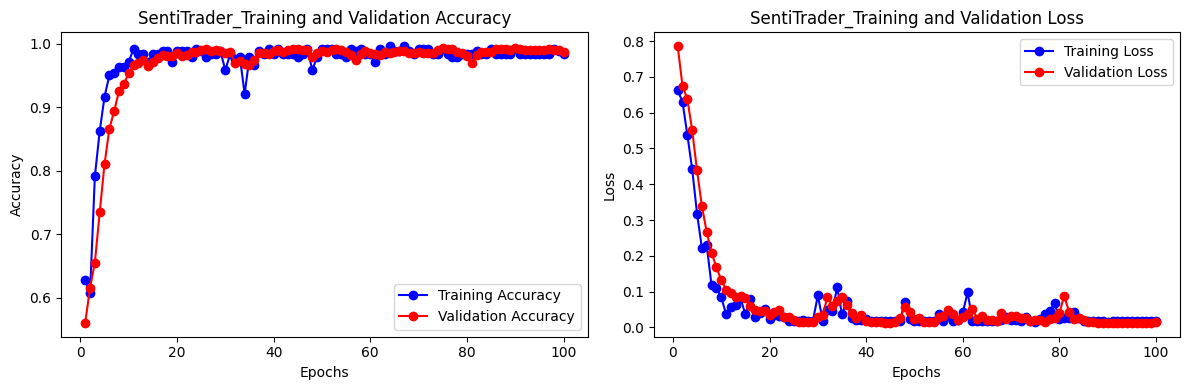

In [ ]:
import matplotlib.pyplot as plt
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]
history=hist
train_accuracy.extend(history.history['acc'])
val_accuracy.extend(history.history['val_acc'])
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

epochs = range(1, len(train_accuracy) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs,val_accuracy , 'bo-', label='Training Accuracy')
plt.plot(epochs, train_accuracy, 'ro-', label='Validation Accuracy')
plt.title('SentiTrader_Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs,val_loss , 'bo-', label='Training Loss')
plt.plot(epochs, train_loss, 'ro-', label='Validation Loss')
plt.title('SentiTrader_Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#ConvLSTM with self attention
from tensorflow.keras.layers import (
    Embedding, Input, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D,
    Dropout, Dense, concatenate, Layer, MultiHeadAttention
)
from tensorflow.keras.models import Model
import tensorflow as tf

class SelfAttention(Layer):
    def __init__(self, num_heads, head_dim, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=head_dim)

    def call(self, inputs):
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        attention_output, attention_scores = self.attention_layer(inputs, inputs, return_attention_scores=True)
        return attention_output  # (batch_size, sequence_length, embedding_dim)

    def get_config(self):
        config = super(SelfAttention, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'head_dim': self.head_dim,
        })
        return config


def ConvBiLSTMAttentionNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    """
    Combines CNN, BiLSTM, and a self-attention mechanism for text classification.
    """
    # Embedding layer
    embedding_layer = Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embeddings],
        input_length=max_sequence_length,
        trainable=False
    )

    # Input layer
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # BiLSTM layer
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)

    # Self-Attention layer
    self_attention_output = SelfAttention(num_heads=8, head_dim=64)(lstm_layer)

    # CNN layers with different filter sizes
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    # Merge CNN and Self-Attention outputs
    cnn_merged = concatenate(convs, axis=1)
    #combined = concatenate([cnn_merged, self_attention_output], axis=1)  # Assuming self_attention_output is a tensor
# Apply GlobalMaxPooling1D to the self-attention output to match the shape of cnn_merged
    self_attention_pooled = GlobalMaxPooling1D()(self_attention_output)

    combined = concatenate([cnn_merged, self_attention_pooled], axis=1)  # Now shapes should match

    # Fully connected layers with dropout
    x = Dropout(0.1)(combined)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    # Build and compile model
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    return model

In [28]:
from sklearn.model_selection import train_test_split

label_names = ['Pos', 'Neg','Neutral']
y_train = data_train[label_names].values
y_test = data_test[label_names].values
x_train = train_cnn_data

# Assign y_train to y_tr
y_tr = y_train

model_with_attention = ConvBiLSTMAttentionNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

# 2. Train the model
num_epochs = 100  # Adjust as needed
batch_size = 32  # Adjust as needed

history_attention = model_with_attention.fit(
    x_train,
    y_tr,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(test_cnn_data, y_test)  # Assuming you have test data ready
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 35, 300)   │  2,392,500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 34, 200)   │    120,200 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 33, 200)   │    180,200 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 32, 200)   │    240,200 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 31, 200)   │    300,200 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 30, 200)   │    360,200 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 35, 128)   │    186,880 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_13[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 200)       │          0 │ conv1d_14[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_2    │ (None, 35, 128)   │    263,808 │ bidirectional_2[… │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1000)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ self_attention_2… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1128)      │          0 │ concatenate_4[0]… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,189,087 (15.98 MB)

 Trainable params: 1,796,587 (6.85 MB)

 Non-trainable params: 2,392,500 (9.13 MB)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - acc: 0.5833 - loss: 0.8389 - val_acc: 0.6025 - val_loss: 0.6496
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step - acc: 0.6262 - loss: 0.6642 - val_acc: 0.6276 - val_loss: 0.6343
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - acc: 0.6674 - loss: 0.6205 - val_acc: 0.7866 - val_loss: 0.5280
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 295ms/step - acc: 0.7662 - loss: 0.5266 - val_acc: 0.8661 - val_loss: 0.4196
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 305ms/step - acc: 0.8254 - loss: 0.4202 - val_acc: 0.8410 - val_loss: 0.3658
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - acc: 0.8515 - loss: 0.3489 - val_acc: 0.9121 - val_loss: 0.2500
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - acc: 0.8971 - loss: 0.2578 - val_acc: 0.9456 - val_loss: 0.1675
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - acc: 0.9203 - loss: 0.2072 - val_acc: 0.9582 - val_loss: 0.1347
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4

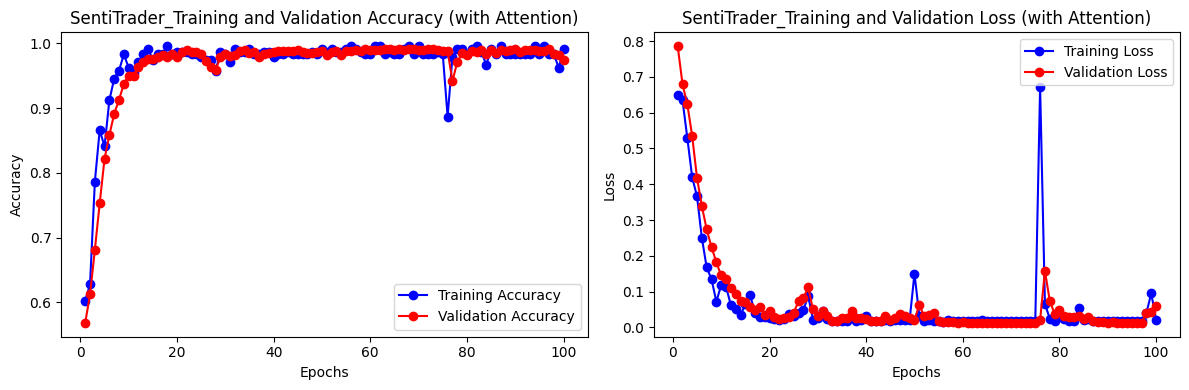

In [29]:
import matplotlib.pyplot as plt
# Store history for ConvBiLSTMAttentionNet

train_accuracy_attention = []
val_accuracy_attention = []
train_loss_attention = []
val_loss_attention = []

# Extract values from history_attention
train_accuracy_attention.extend(history_attention.history['acc'])
val_accuracy_attention.extend(history_attention.history['val_acc'])
train_loss_attention.extend(history_attention.history['loss'])
val_loss_attention.extend(history_attention.history['val_loss'])

# Epochs for ConvBiLSTMAttentionNet
epochs_attention = range(1, len(train_accuracy_attention) + 1)

# Plotting for ConvBiLSTMAttentionNet
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_attention, val_accuracy_attention, 'bo-', label='Training Accuracy')
plt.plot(epochs_attention, train_accuracy_attention, 'ro-', label='Validation Accuracy')
plt.title('SentiTrader_Training and Validation Accuracy (with Attention)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_attention, val_loss_attention, 'bo-', label='Training Loss')
plt.plot(epochs_attention, train_loss_attention, 'ro-', label='Validation Loss')
plt.title('SentiTrader_Training and Validation Loss (with Attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Assuming TRAINING_VOCAB contains all unique words in your training set
vocab_size = len(TRAINING_VOCAB) + 1  # Add 1 for padding/out-of-vocabulary token
# or
# vocab_size = len(train_word_index) + 1

# You need to define these based on your data and model configuration:
embedding_dim = 300  # Example value, adjust as needed
max_length = 35     # Example value, adjust as needed
num_classes = 3      # Example value, adjust as needed

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(num_classes, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


lstm_history = lstm_model.fit(x_train, y_tr, epochs=num_epochs, batch_size=batch_size, validation_data=(test_cnn_data, y_test))


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.5681 - loss: 0.8041 - val_accuracy: 0.6025 - val_loss: 0.6419
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6824 - loss: 0.6271 - val_accuracy: 0.9372 - val_loss: 0.2596
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9089 - loss: 0.2808 - val_accuracy: 0.9749 - val_loss: 0.0983
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9694 - loss: 0.1259 - val_accuracy: 0.9874 - val_loss: 0.0709
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9795 - loss: 0.0799 - val_accuracy: 0.9874 - val_loss: 0.0405
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9752 - loss: 0.0735 - val_accuracy: 0.9916 - val_loss: 0.0346
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9883 - loss: 0.0474 - val_accuracy: 0.9916 - val_loss: 0.0325
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9862 - loss: 0.0327 - val_accur

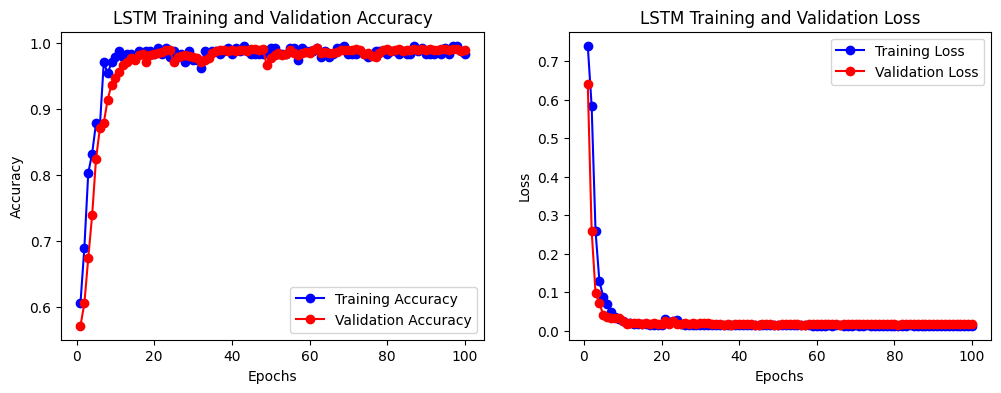

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained the LSTM model and stored the training history in 'lstm_history'
plt.figure(figsize=(12, 4))
# Get the training and validation loss values from the history
train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs,val_accuracy , 'bo-', label='Training Accuracy')
plt.plot(epochs, train_accuracy, 'ro-', label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# DistilBERT Model

# DistilBERT Model

from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

# Load pre-trained tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
distilbert = TFDistilBertModel.from_pretrained(model_name)

# Define model parameters
max_length = 35
num_classes = 3  # Adjust based on your classification problem
batch_size = 16

# Define input layers
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Define a function for DistilBERT embeddings
def distilbert_layer(inputs):
    input_ids_tensor, attention_mask_tensor = inputs
    outputs = distilbert(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
    return outputs.last_hidden_state[:, 0, :]  # Use [CLS] token for classification

# Apply Lambda with explicit output shape
x = Lambda(distilbert_layer, output_shape=(768,))([input_ids, attention_mask])
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create and compile the model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tokenize and prepare data
train_encodings = tokenizer(data_train["Text_Final"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = tokenizer(data_test["Text_Final"].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Extract labels for training and testing (y_train, y_test)
label_names = ['Pos', 'Neg', 'Neutral']
y_train = data_train[label_names].values  # Define y_train here
y_test = data_test[label_names].values

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {k: v for k, v in train_encodings.items()},
    y_train  # Now y_train is defined
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {k: v for k, v in test_encodings.items()},
    y_test
)).batch(batch_size)

# Train the model
distilbert_history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5361 - loss: 0.8256 - val_accuracy: 0.5732 - val_loss: 0.6746
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5845 - loss: 0.7129 - val_accuracy: 0.5774 - val_loss: 0.6696
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5872 - loss: 0.7012 - val_accuracy: 0.6067 - val_loss: 0.6630
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.6018 - loss: 0.6942 - val_accuracy: 0.6025 - val_loss: 0.6590
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5858 - loss: 0.6886 - val_accuracy: 0.5983 - val_loss: 0.6607
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5849 - loss: 0.6887 - val_accuracy: 0.5941 - val_loss: 0.6582
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5936 - loss: 0.6839 - val_accuracy: 0.6109 - val_loss: 0.6552
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6023 - loss: 0.6825 - 

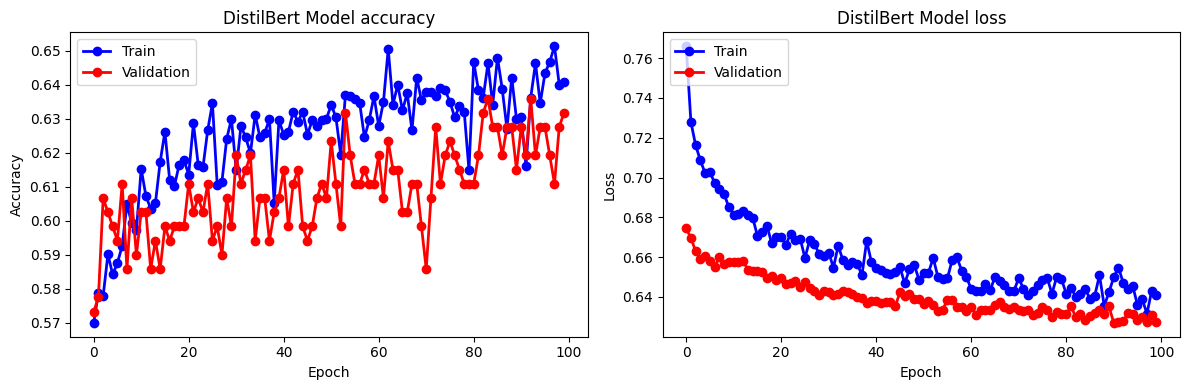

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 2, 1)
# Plot with bold lines and specified colors
plt.plot(distilbert_history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
plt.plot(distilbert_history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
plt.title('DistilBert Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
# Plot with bold lines and specified colors
plt.plot(distilbert_history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
plt.plot(distilbert_history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
plt.title('DistilBert Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [30]:
# 6. Online Learning with News API Data
newsapi = NewsApiClient(api_key='da06d4ed-d76d-4220-ba6e-467a7d14e86d')

def get_news_data(query, num_articles=5): DXPu2ySBfEM3QWGuGyWncggUIoFShHQnUXcBtCEL
    """Fetches news articles from the News API and preprocesses them."""
    all_articles = []
    for page in range(1, 6):  # Fetch up to 5 pages of results
        articles = newsapi.get_everything(q=query, language='en', page_size=20, page=page)['articles']
        all_articles.extend(articles)
        if len(all_articles) >= num_articles:
            break
    news_df = pd.DataFrame(all_articles)
    news_df['Text_Clean'] = news_df['title'].apply(lambda x: remove_punct(x))

    # Tokenization using the pre-trained tokenizer
    news_sequences = tokenizer.texts_to_sequences(news_df["Text_Clean"].tolist())

    # Padding to MAX_SEQUENCE_LENGTH
    news_padded = pad_sequences(news_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Add the padded sequences to the DataFrame (optional, for easier access later)
    news_df['Padded_Tokens'] = news_padded.tolist()
    return news_df

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric = metrics.Accuracy()
drift_detector = drift.ADWIN()

from textblob import TextBlob

def get_sentiment_label(text):
    """Uses TextBlob to get sentiment label."""
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity

    if sentiment > 0.1:
        return [1, 0, 0]  # Positive sentiment
    elif sentiment < -0.1:
        return [0, 1, 0]  # Negative sentiment
    else:
        return [0, 0, 1]  # Neutral sentiment



for i in range(1000):
    news_df = get_news_data(query='stock market', num_articles=100)  # Customize the query
    for _, row in news_df.iterrows():
        text = row['Text_Clean']
        # Preprocess the text
        tokens = tokenizer.texts_to_sequences([text])
        padded_tokens = pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH)

        # Get sentiment label for the news data
        label = get_sentiment_label(text)
        label = np.array(label)  # Convert to NumPy array

        with tf.GradientTape() as tape:
            predictions = model(padded_tokens)  # Use the attention model for online learning
            loss = loss_fn(label, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        predicted_class = np.argmax(predictions.numpy())
        true_class = np.argmax(label)

        metric.update(true_class, predicted_class)
        drift_detector.update(true_class == predicted_class)

        if drift_detector.drift_detected:
            print(f"Concept drift detected at instance {i}!")
            # You might want to reset the model or retrain on a recent data window here
            # Example: model = create_online_convbilstm_attention_model(...) # Reset

        if (i + 1) % 100 == 0:  # Print metrics every 100 instances
            print(f"Instance: {i + 1}, Accuracy: {metric.get()}")

NewsAPIException: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}

In [38]:
!pip install requests
!pip install river
!pip install textblob
import requests
import json
import tensorflow as tf
from river import drift
from river import metrics
from textblob import TextBlob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import re
import string
import pandas as pd  # Make sure pandas is imported


# 1. Load the pre-trained model and tokenizer
model = load_model('StockNewssentiment.h5', custom_objects={'SelfAttention': SelfAttention})  # Replace with your model filename
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# 2. Define constants
MAX_SEQUENCE_LENGTH = 35  # Replace with your sequence length during training
MARKETAUX_API_KEY = 'DXPu2ySBfEM3QWGuGyWncggUIoFShHQnUXcBtCEL'  # Replace with your MarketAux API key


# 3. Define helper functions
def get_news_data(num_articles=100):
    """Fetches financial news from the free market_news endpoint."""
    url = 'https://financialmodelingprep.com/api/v3/market_news'
    params = {'apikey': '5rDZpjD1nFoYDVeWfyq9txnp96y6IRnL', 'limit': num_articles}

    response = requests.get(url, params=params)

    # Check for successful response
    if response.status_code != 200:
        print(f"Error fetching news data: Status code {response.status_code}")
        print(response.text)
        return pd.DataFrame()

    news_articles = response.json()

    # Check for empty data
    if not news_articles:
        print("No news articles found.")
        return pd.DataFrame()

    news_df = pd.DataFrame(news_articles)

    # Adjust to expected column names in the market_news response
    if 'title' not in news_df.columns:
        if 'headline' in news_df.columns:
            title_column = 'headline'
        else:
            # Add checks for other potential names if needed
            raise KeyError("Neither 'title' nor 'headline' found in news data")
    else:
        title_column = 'title'  # Use 'title' if it exists

    # Preprocessing
    news_df['Text_Clean'] = news_df[title_column].apply(lambda x: remove_punct(x))
    news_sequences = tokenizer.texts_to_sequences(news_df["Text_Clean"].tolist())
    news_padded = pad_sequences(news_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    news_df['Padded_Tokens'] = news_padded.tolist()

    return news_df

    # Check for title column and fallback to headline
    if 'title' not in news_df.columns:
        if 'headline' in news_df.columns:
            title_column = 'headline'
        else:
            raise KeyError("Neither 'title' nor 'headline' found in news data")
    else:
        title_column = 'title'

    news_df['Text_Clean'] = news_df[title_column].apply(lambda x: remove_punct(x))
    news_sequences = tokenizer.texts_to_sequences(news_df["Text_Clean"].tolist())
    news_padded = pad_sequences(news_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    news_df['Padded_Tokens'] = news_padded.tolist()

    return news_df


def get_sentiment_label(text):
    """Uses TextBlob to get sentiment label."""
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity

    if sentiment > 0.1:
        return [1, 0, 0]  # Positive sentiment
    elif sentiment < -0.1:
        return [0, 1, 0]  # Negative sentiment
    else:
        return [0, 0, 1]  # Neutral sentiment


def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('[' + string.punctuation + ']', '', text)
    return text_nopunct


# 4. Online learning loop
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric = metrics.Accuracy()
drift_detector = drift.ADWIN()

for i in range(1000):  # Adjust the number of iterations as needed
    news_df = get_news_data(num_articles=100)  # Get all financial news
    for _, row in news_df.iterrows():
        text = row['Text_Clean']
        padded_tokens = np.array([row['Padded_Tokens']])  # Convert to NumPy array

        label = get_sentiment_label(text)
        label = np.array(label)  # Convert to NumPy array

        with tf.GradientTape() as tape:
            predictions = model(padded_tokens)  # Use your trained sentiment analysis model

            # Reshape label to match predictions shape
            loss = loss_fn(label[np.newaxis, ...], predictions) # Reshape label to (1, 3)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        predicted_class = np.argmax(predictions.numpy())
        true_class = np.argmax(label)

        metric.update(true_class, predicted_class)
        drift_detector.update(true_class == predicted_class)

        if drift_detector.drift_detected:
            print(f"Concept drift detected at instance {i}!")
            # Handle concept drift (e.g., reset or retrain model)

        if (i + 1) % 100 == 0:  # Print metrics every 100 instances
            print(f"Instance: {i + 1}, Accuracy: {metric.get()}")

Error fetching news data: Status code 429
{
  "Error Message": "Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/"
}
Error fetching news data: Status code 429
{
  "Error Message": "Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/"
}
Error fetching news data: Status code 429
{
  "Error Message": "Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/"
}
Error fetching news data: Status code 429
{
  "Error Message": "Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/"
}
Error fetching news data: Status code 429
{
  "Error Message": "Limit Reach . Please upgrade your plan or visit our documentation for more details at https://site.financialmodelingprep.com/"
}
Error fetching news data: Status co

KeyboardInterrupt: 

In [ ]:
!pip install scikit-learn matplotlib seaborn pandas tensorflow transformers
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

# Assuming you have loaded/trained your models and data:
# - test_cnn_data: Test data for CNN-based models
# - y_test: True labels for the test data (one-hot encoded)
# - model (ConvBiLSTMAttentionNet), convbilstm_model, lstm_model, cnn_model (optional), distilbert_model (optional)

# ... (Load your models and data here if needed) ...


def evaluate_model(model, test_data, true_labels, model_name):
    """Evaluates a model and returns a dictionary of metrics."""

    # Check if the model is the ConvBiLSTMAttentionNet or DistilBERT model
    if model_name in ["ConvBiLSTMAttentionNet", "DistilBERT"]:
        # If it's either of these models, expect two inputs: input_ids and attention_mask
        if model_name == "ConvBiLSTMAttentionNet":
            # For ConvBiLSTMAttentionNet, test_data is test_cnn_data
            # Create a dummy attention mask for ConvBiLSTMAttentionNet (all ones)
            attention_mask = np.ones_like(test_data)
            predictions = model.predict([test_data, attention_mask])  # Pass both inputs
        else:
            # For DistilBERT, test_data is test_encodings
            predictions = model.predict({
                'input_ids': test_data['input_ids'],
                'attention_mask': test_data['attention_mask']
            })
    else:
        # For other models, use the original test_data
        predictions = model.predict(test_data) # Get model predictions

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(true_classes, predicted_classes),
        'Precision': precision_score(true_classes, predicted_classes, average='weighted'),
        'Recall': recall_score(true_classes, predicted_classes, average='weighted'),
        'F1-Score': f1_score(true_classes, predicted_classes, average='weighted'),
        'AUC': roc_auc_score(true_labels, predictions, average='weighted', multi_class='ovr')
    }

    return metrics

def plot_confusion_matrix(model, test_data, true_labels, model_name):
    """Plots the confusion matrix for a model."""
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pos', 'Neg', 'Neutral'],
                yticklabels=['Pos', 'Neg', 'Neutral'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate each model and store results
results = []
results.append(evaluate_model(model, test_cnn_data, y_test, "ConvBiLSTMAttentionNet"))
results.append(evaluate_model(convbilstm_model, test_cnn_data, y_test, "ConvBiLSTMNet"))  # Without Attention
results.append(evaluate_model(lstm_model, test_cnn_data, y_test, "LSTM"))
# results.append(evaluate_model(cnn_model, test_cnn_data, y_test, "CNN"))  # Uncomment if using CNN
#Load pre-trained tokenizer and model for DistilBERT if you are using it
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
distilbert = TFDistilBertModel.from_pretrained(model_name)
test_encodings = tokenizer(data_test["Text_Final"].tolist(), truncation=True, padding=True, max_length=35, return_tensors='tf')
results.append(evaluate_model(distilbert_model, test_encodings, y_test, "DistilBERT"))  # Uncomment if using DistilBERT

# Create DataFrame from results
results_df = pd.DataFrame(results)
print(results_df)

# Plot confusion matrices
plot_confusion_matrix(model, test_cnn_data, y_test, "ConvBiLSTMAttentionNet")
plot_confusion_matrix(convbilstm_model, test_cnn_data, y_test, "ConvBiLSTMNet")
plot_confusion_matrix(lstm_model, test_cnn_data, y_test, "LSTM")
# plot_confusion_matrix(cnn_model, test_cnn_data, y_test, "CNN")  # Uncomment if using CNN
plot_confusion_matrix(distilbert_model, test_encodings, y_test, "DistilBERT")  # Uncomment if using DistilBERT

NameError: name 'model_with_attention' is not defined